In [1]:
# default_exp data.core 

In [2]:
# hide
import sys

sys.path.append("..")
import pandas as pd

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
# hide
from nbdev.showdoc import *

# Data Core

> Using the fastai2 `Datasets` to make an time series dataset.


In [150]:
# export
from fastseq.data.load import *
from fastseq.core import *
from fastcore.all import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.data.transforms import *
from fastai2.tabular.core import *
from fastseq.data.load import *
import orjson

In [8]:
# hide
# just check previous nb still works. Sometimes import errors
horizon,lookback = 2,5
df = get_df([160, 160, 160])
path = Path('../data/test_data')
save_df(df, path)
dl = MTSDataLoader.from_path(path, y_name = 'x', lookback= lookback, horizon = horizon)
test_eq(dl.n, len(dl._ids))
test_eq(dl.n, 2456)
test_eq(len(dl),39)
for o in dl:pass

# Transforms

> Basic function to process time-series data before assembling it in a `DataLoaders`.

## Normalize

In [9]:
# export
def _zeros_2_ones(o, eps=1e-8):
    nan_mask = o!=o
    o[o < eps ] = 1    
    o[nan_mask ] = 1    
    return o
    

In [10]:
o = np.arange(0,1,.1)
test_close(list(_zeros_2_ones(o,.5)),[1. , 1. , 1. , 1. , 1. , 0.5, 0.6, 0.7, 0.8, 0.9])

o = np.arange(0,1,.1)[None,:]
test_close(list(_zeros_2_ones(o,.5)),[[1. , 1. , 1. , 1. , 1. , 0.5, 0.6, 0.7, 0.8, 0.9]])

o = torch.arange(0,1,.1)[None,:]
test_close(_zeros_2_ones(o,.5),tensor([[1. , 1. , 1. , 1. , 1. , 0.5, 0.6, 0.7, 0.8, 0.9]]))

o = torch.arange(0,1,.1)[None,:]
o[:,-1]= torch.tensor(float('nan'))
test_close(_zeros_2_ones(o,.5),tensor([[1. , 1. , 1. , 1. , 1. , 0.5, 0.6, 0.7, 0.8, 1]]))

o = np.arange(0,1,.1)[None,:]
o[:,-1]= np.nan
test_close(list(_zeros_2_ones(o,.5)),[[1. , 1. , 1. , 1. , 1. , 0.5, 0.6, 0.7, 0.8, 1]])

/home/tako/dev/env37/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


### old

In [11]:
import warnings
class NormalizeTSMulti(ItemTransform):
    "Normalize the Time-Series."
    def __init__(self, to_norm=['TensorCon','TensorSeq'], verbose=False, make_ones=True, eps=1e-7, mean = None):
        """
        `make_ones` will make the std 1 if the std is smaller than `10*eps`.
        This is for blok seqences to not magnify the `y` part of the data.

        `mean` will set a mean instead of the mean of the x value.
        (
            TensorSeqs(x, label=[self.y_name + '_x'], m=['g']),
            TensorSeqs(tsx,label=self.ts_names),
            TensorCon(cat,label=self.cat_names).long(),
            TensorCon(con,label=self.con_names),
            TensorSeqs(y, label=[self.y_name+ '_y'], m=['r'])
        )
        """
        store_attr(self,'verbose, make_ones, eps, mean,to_norm')
        self.m, self.s = {}, {}
        warnings.warn("NormalizeTSMulti is depricated. Please use `NormalizeSeqsMulti`")

    def encodes(self, o):
        for i in range(len(o)-1):
            self.m[i], self.s[i] = 0, 1
            if type(o[i]) == TensorCon and o[i].shape[-1]>0: # if tensor has shape (bs,0) than ignore
                if 'TensorCon' in self.to_norm:
                    self.m[i] = torch.mean(o[i])
                    self.s[i] = torch.std(o[i]) + self.eps 
            elif type(o[i]) == TensorSeq:
                if 'TensorSeq' in self.to_norm:
                    self.m[i] = torch.mean(o[i], -1, keepdim=True)
                    self.s[i] = torch.std(o[i],  -1, keepdim=True) +self.eps
                    self.s[i] = _zeros_2_ones(self.s[i], self.eps*10)
            elif self.verbose:
                if o[i].shape[-1]>0 and not type(o[i]) == TensorCatI:
                    print(f'NormalizeTSMulti:type {type(o[i])} on location:{i}/{len(o)} of tuple not found')
                
        # y must be scaled with m
        self.m[len(o)-1], self.s[len(o)-1] = self.m[0],self.s[0] 
        # TODO make y its own type
        if self.verbose:
            print('encodes',[a.shape for a in o],'m shape', {k:o.shape for k,o in self.m.items()},'s shape',{k:o.shape for k,o in self.s.items()})
        
        return TSMulti_([(o[i]-self.m[i]) / self.s[i] for i in range(len(o))])       
    
    def decodes(self, o):
        if o[0].is_cuda:
            self.m, self.s = to_device(self.m,'cuda'), to_device(self.s,'cuda')
            if sum([a.is_cuda for a in o]) != len(o):
                o = Tuple([to_device(a,'cuda') for a in o])
        else:
            if sum([a.is_cuda==False for a in o]) != len(o):
                o = Tuple([to_cpu(a) for a in o])
            self.m, self.s = to_cpu(self.m), to_cpu(self.s)
        if self.verbose:
            print('decodes',[a.shape for a in o],  {k:o.shape for k,o in self.m.items()},'s shape',{k:o.shape for k,o in self.s.items()})
        return TSMulti_([(o[i]*self.s[i])+self.m[i] for i in range(len(o))])

In [12]:
o = TSMulti_(TensorSeq(np.arange(12.)),1,2,TensorSeq(np.arange(-1,11.)))
tmf = NormalizeTSMulti()
o_tmf = tmf(o)


/home/tako/dev/env37/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: NormalizeTSMulti is depricated. Please use `NormalizeSeqsMulti`


In [13]:
%%timeit
o_tmf = tmf(o)

402 µs ± 6.82 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### new

In [14]:
# export
class NormalizeSeq(Transform):
    def __init__(self, verbose=False, make_ones=True, eps=1e-7, mean = None):
        store_attr(self,'verbose, make_ones, eps, mean')
        self.m, self.s = 0, 1
        
    def to_same_device(self, o):    
        if o.is_cuda:
            self.m, self.s = to_device(self.m,'cuda'), to_device(self.s,'cuda')
        else:
            self.m, self.s = to_cpu(self.m), to_cpu(self.s)     
            
    def encodes(self, o: TensorSeq):
        self.m = torch.mean(o, -1, keepdim=True)
        self.s = torch.std(o,  -1, keepdim=True) +self.eps
        if (self.s < self.eps*10).sum():
            self.s = _zeros_2_ones(self.s, self.eps*10)
        if self.verbose:
            print('encodes',[a.shape for a in o],
                  'm shape', {k:o.shape for k,o in self.m.items()},
                  's shape',{k:o.shape for k,o in self.s.items()})
        
        return self.norm(o)
    
    def norm(self, o):
        return (o - self.m)/self.s
    
    def decodes(self, o: TensorSeq):
        if self.verbose:
            print('decodes',o.shape,  
                  'm shape',self.m.shape,
                  's shape',self.s.shape)
        return self.denorm(o)
    
    def denorm(self, o):
        self.to_same_device(o)
        return (o*self.s)+self.m 

In [15]:
tmf = NormalizeSeq()
o = TensorSeq(TensorSeq([np.arange(12.)]*16))
o_tmf = tmf(o)
test_close(o_tmf.mean(),0)
test_eq(tmf.decode(o_tmf),TensorSeq([np.arange(12.)]*16))

In [17]:
# export
class NormalizeSeqMulti(ItemTransform):
    """A shell Transformer to normalize `TensorSeqs` inside `TSMulti_` with `NormalizeSeqs`. """
    @delegates(NormalizeSeq.__init__)
    def __init__(self, n_its=5, **kwargs):
        """`n_its` does not include the ts to predict."""
        self.f = {i:NormalizeSeq(**kwargs) for i in range(n_its)}
        self.n = n_its
        
    def encodes(self, o:TSMulti_):
        r = L()
        for i,a in enumerate(o):
            if type(a) is not TensorSeq:
                r.append(a)
            elif i < (self.n-1):
                r.append(self.f[i](a))
            else:
                r.append(self.f[0].norm(o[i]))
        return TSMulti_(r)
    
    def decodes(self, o:TSMulti_): 
        r = L(self.f[i].decode(a) for i,a in enumerate(o[:-1]))
        r.append(self.f[0].denorm(o[-1]))
        return TSMulti_(r)
    

In [18]:
o = TSMulti_(TensorSeq([np.arange(12.)]*16),
             [1]*16,
             [2]*16,
             TensorSeq([np.arange(-2,10.)]*16))
tmf = NormalizeSeqMulti(len(o))
o_tmf = tmf(o)
test_close(o_tmf[0].mean(),0)
test_eq(o_tmf[1], o[1])
test_eq(torch.round(o_tmf[3].mean()), -1)

In [19]:
o = TSMulti_(TensorSeq([[np.arange(12.)]]*16),
             [1]*16,
             [2]*16,
             TensorSeq([[np.arange(-2,10.)]]*16))
tmf = NormalizeSeqMulti(len(o))
o_tmf = tmf(o)
test_close(o_tmf[0].mean(),0)
test_eq(o_tmf[1], o[1])
test_eq(torch.round(o_tmf[3].mean()), -1)

In [20]:
o = TSMulti_(TensorSeq(np.arange(12.)),1,2,TensorSeq(np.arange(-1,11.)))
tmf = NormalizeSeqMulti(len(o))
o_tmf = tmf(o)

test_close(o_tmf[0].mean(),0);test_close(o_tmf[0].std(),1);
test_eq(o_tmf[1],1)
test_eq(o_tmf[2],2)
# Note the y has not mean 0 because it is normalized with the stats of the first item in the tuple
test_close(o_tmf[3].mean(),-0.27,.1); test_close(o_tmf[3].std(),1); 
test_eq(tmf.decode(o_tmf), o)
def prof_func():
    tmf(o)

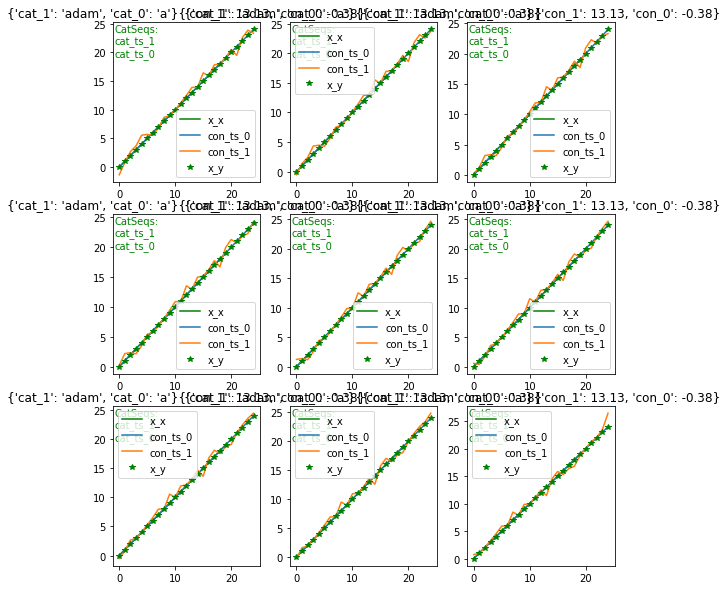

In [36]:
path = Path('../data/test_data')

dl = MTSDataLoader.from_path(path, y_name = 'x', lookback = 20, horizon = 5, num_workers = 0,
                            after_batch = NormalizeSeqMulti())
dl.show_batch()

In [38]:
# hide
for o in dl:
    for a in o[:-1]:
        if a.shape[-1] > 0 and type(a) is TensorSeq:    
            test_close(a.mean(-1), 0)
            test_close(a.std(),1, .1)
    test_close(o[0][:,:,:lookback],o[-1][:,:,:lookback],.1)
    test_eq(type(o),TSMulti_)
    o_new = dl.after_batch[0].decode(o)
    test_eq(o_new[0].mean()!=0, True)
    test_eq(o_new[0].std()!=1, True)
    break
    
test_eq(type(dl.one_batch()), TSMulti_)

# TSDataLoaders

## Utils

In [128]:
# export 
def make_test(ts:dict, horizon:int, lookback:int, keep_lookback:bool = False):
    """Splits the every ts in `items` based on `horizon + lookback`*, where the last part will go into `val` and the first in `train`.
    *if `keep_lookback`:
        it will only remove `horizon` from `train` otherwise will also remove lookback from `train`.
    """
    train,val = {},{}
    for k,v in ts.items():
        if k in ['ts_con','ts_cat']:
            if keep_lookback:
                train[k] = [o[:-(horizon)] for o in v]
            else:                    
                train[k] = [o[:-(horizon+lookback)] for o in v]
            val[k] = [o[-(horizon+lookback):] for o in v]                
        elif k == '_length':
            train[k] = {k: v - (horizon if keep_lookback else horizon+lookback)}
            val[k] = {k:horizon+lookback}
        else:
            train[k] = v
            val[k] = v   
    return train, val

In [129]:
horizon,lookback = 2,5
df = get_df([14, 14, 16])
path = Path('../data/test_data')
save_df(df, path)
ts = get_ts_datapoint(get_files(path, extensions='.json')[0])
t, v = make_test(ts,horizon,lookback, True)
for i in range(len(t['ts_con'])):
    test_eq(t['ts_con'][i],ts['ts_con'][i][:-(horizon)])
for i in range(len(t['ts_con'])):
    test_eq(v['ts_con'][i],ts['ts_con'][i][-(horizon+lookback):])
    
t, v = make_test(ts,horizon,lookback, False)
for i in range(len(t['ts_con'])):
    test_eq(t['ts_con'][i],ts['ts_con'][i][:-(horizon+lookback)])
for i in range(len(t['ts_con'])):
    test_eq(v['ts_con'][i],ts['ts_con'][i][-(horizon+lookback):])

In [165]:
# export
@delegates(make_test)
def split_file(file, clean=True, **kwargs):
    ts = get_ts_datapoint(file)
    t, v = make_test(ts, **kwargs)   
    fs = []
    for f, dct in zip(['train','val'], [t,v]):
        new_f = Path(*str(file).split(os.sep)[:-1]) / f / str(file).split(os.sep)[-1]
        if not new_f.parent.exists(): new_f.parent.mkdir()
        open(new_f,'wb').write(orjson.dumps(t))
        fs.append(new_f)
    if clean:
        os.remove(file)
    return fs

In [168]:
horizon,lookback = 2,5
df = get_df([14, 14, 16])
path = Path('../data/test_data')
save_df(df, path)
split_file(get_files(path, extensions='.json')[0], horizon=horizon, lookback=lookback)

[Path('../data/test_data/train/2.json'), Path('../data/test_data/val/2.json')]

## Dataloaders

In [28]:
#export
class DfDataLoaders(DataLoaders):
    @classmethod
    @delegates(DfDataLoader.__init__)
    def from_df(cls, dataset:pd.DataFrame, y_name:str, horizon:int, valid_pct=1.5, seed=None, lookback=None, step=1,
                   incl_test = True, path:Path='.', device=None, norm=True, **kwargs):
        """Create an list of time series.
        The `DataLoader` for the test set will be save as an attribute under `test`
        """
        lookback = ifnone(lookback, horizon * 4)
        device = ifnone(device, default_device())
        if incl_test:
            dataset, test = make_test_df(dataset, horizon, lookback, keep_lookback = True)
        train, valid = make_test_df(dataset, horizon + int(valid_pct*horizon), lookback , keep_lookback = True)
        if norm and 'after_batch' not in kwargs:
            kwargs.update({'after_batch':L(NormalizeSeqsMulti(n_its=4))})
        db = DataLoaders(*[DfDataLoader(ds, y_name, horizon=horizon, lookback=lookback, step=step,
                                        device=device, **kwargs)
                           for ds in [train,valid]], path=path, device=device)
        if incl_test:
            db.test = DfDataLoader(test, y_name, horizon=horizon, lookback=lookback, step=step, device=device, **kwargs)

            print(f"Train:{db.train.n}; Valid: {db.valid.n}; Test {db.test.n}")
        else:
            print(f"Train:{db.train.n}; Valid: {db.valid.n}")

        return db

In [29]:
# hide
# device series
horizon,lookback = 2,5
t = np.arange(-5,25)
a = np.sin(t)
df = pd.DataFrame({'pred':[pd.Series(i + (i*.6)*a*-.5) for i in range(1,100)],
                   'a':[i+a for i in range(1,100)]})
df.head(1)

,pred,a
0,0 0.712323 1 0.772959 2 1.042336 3 1.272789 4 1.252441 5 1.000000 6 0.747559 7 0.727211 8 0.957664 9 1.227041 10 1.287677 11 1.083825 12 0.802904 13 0.703193 14 0.876364 15 1.163206 16 1.299997 17 1.160972 18 0.873950 19 0.702818 20 0.804914 21 1.086371 22 1.288419 23 1.225296 24 0.955037 25 0.726116 26 0.749003 27 1.002655 28 1.253866 29 1.271674 dtype: float64,"[1.9589242746631386, 1.7568024953079282, 0.8588799919401328, 0.09070257317431829, 0.1585290151921035, 1.0, 1.8414709848078965, 1.9092974268256817, 1.1411200080598671, 0.2431975046920718, 0.041075725336861546, 0.7205845018010741, 1.656986598718789, 1.989358246623382, 1.4121184852417565, 0.4559788891106302, 9.793449296524592e-06, 0.46342708199956506, 1.420167036826641, 1.9906073556948702, 1.6502878401571168, 0.7120966833349347, 0.03860250812044319, 0.24901275322832395, 1.1498772096629524, 1.9129452507276277, 1.836655638536056, 0.9911486907095961, 0.15377959582482936, 0.0944216379933761]"


In [169]:
# hide
from nbdev.export import *

notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 02_data.load.ipynb.
Converted 030_data.m5.ipynb.
Converted 03_data.core.ipynb.
Converted 050_nbeats.models_multi.ipynb.
Converted 05_nbeats.models.ipynb.
Converted 06_nbeats.callbacks.ipynb.
Converted 07_nbeats.learner.ipynb.
Converted 08_nbeats.interpret.ipynb.
Converted 11_metrics.ipynb.
Converted 12_compare.ipynb.
Converted index.ipynb.
Converted tab.model.ipynb.


In [170]:
git_add('03_data.core.ipynb', commit_msg='split ts_files')

Converted 03_data.core.ipynb.


['/home/tako/dev/fastseq/fastseq/data/core.py',
 '/home/tako/dev/fastseq/nbs/03_data.core.ipynb']